In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input,MaxPooling2D,Conv2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample # downsample the dataset
from sklearn.model_selection import train_test_split # split data into training and testing sets
from sklearn.svm import SVC # this will make a support vector machine for classificaiton
from sklearn.model_selection import GridSearchCV #this will do cross validation
from sklearn.metrics import confusion_matrix # this creates a confusion matrix
from sklearn.decomposition import PCA # to perform PCA to plot the data
from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from PIL import Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


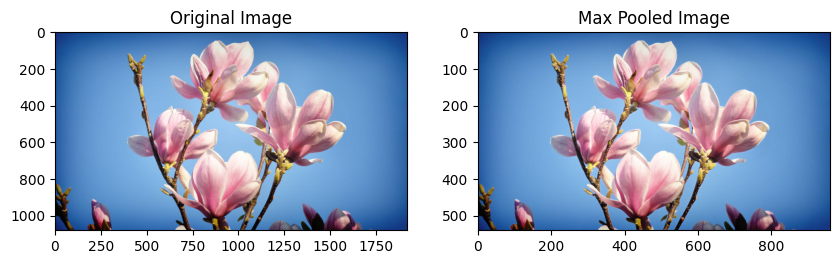

<MaxPooling2D name=max_pooling2d_3, built=True>


In [6]:
img_path = './images/353.jpg'  
img = load_img(img_path)
img_array = img_to_array(img)

model = Sequential([
    Input(shape=(img_array.shape),batch_size=1),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
])

# expand the dim of the image so img_array have the dimen needed to go to the model
#(height,width,channels=3) => (batchsize=1,height,width,channels=3)
img_array = np.expand_dims(img_array, axis=0)

pooled_img_array = model.predict(img_array)

# so the output has the dim of (1,height,width,3) so we need to squeeze the first dim to have real image
#(1,height,width,3) => (height,width,3)
pooled_img_array = np.squeeze(pooled_img_array, axis=0)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.title("Max Pooled Image")
plt.imshow(pooled_img_array.astype('uint8'))
plt.imsave('images/max_pooled_image.png', pooled_img_array.astype('uint8'))
plt.show()
print(model.layers[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


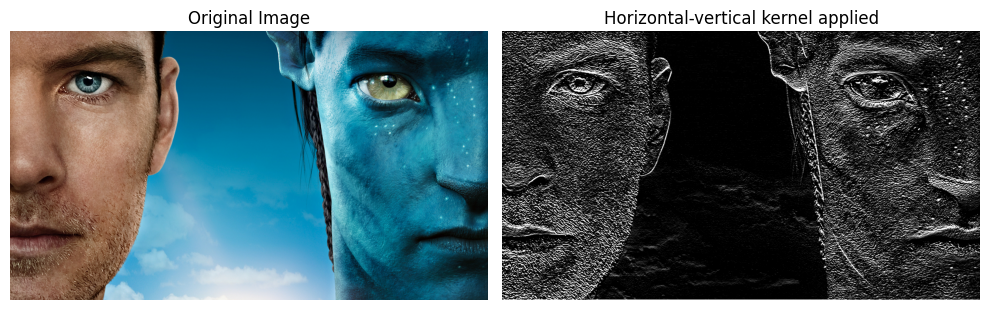

In [16]:
img_path = './images/360.jpg'  
img = load_img(img_path)
img_array = img_to_array(img)
img_array = img_array/255
model = Sequential([
    Input(shape=(img_array.shape),batch_size=1),
    Conv2D(filters=1, kernel_size=(3, 3), use_bias=False,padding='same'),  
    Conv2D(filters=1, kernel_size=(3, 3), use_bias=False,padding='same')  
])
#(e.g., horizontal edge detection)
horizontal_edge_kernel = np.array([[-1, 0, 1],
                            [-1, 0, 1],
                            [-1, 0, 1]], dtype='float32')

#(e.g., vertical edge detection)
vertical_edge_kernel = np.array([[1, 1, 1],
                          [0, 0, 0],
                          [-1, -1, -1]], dtype='float32')
horizontal_edge_kernel = horizontal_edge_kernel.reshape((3, 3, 1, 1))
vertical_edge_kernel = vertical_edge_kernel.reshape((3, 3, 1, 1))

model.layers[0].set_weights([np.repeat(horizontal_edge_kernel, 3, axis=2)])
model.layers[0].set_weights([np.repeat(vertical_edge_kernel, 3, axis=2)])
# expand the dim of the image so img_array have the dimen needed to go to the model
#(height,width,channels=3) => (batchsize=1,height,width,channels=3)
img_array = np.expand_dims(img_array, axis=0)

output_image = model.predict(img_array)

# so the output has the dim of (1,height,width,3) so we need to squeeze the first dim to have real image
#(1,height,width,3) => (height,width,3)
output_image = np.squeeze(output_image, axis=0)
output_image = np.clip(output_image * 255, 0, 255)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.axis("off")
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.title("Horizontal-vertical kernel applied")
plt.imshow(output_image.astype('uint8'),cmap='gray')
plt.axis("off")
plt.tight_layout()

plt.savefig('images/kernel-applied.png')
plt.show()

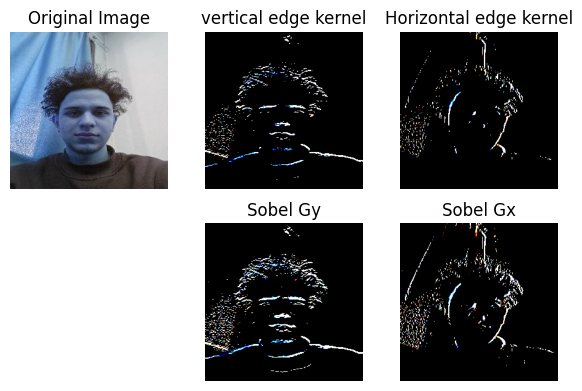

In [11]:
from scipy.ndimage import convolve
img_path = './images/me.jpg'  
img = load_img(img_path)
img_array = img_to_array(img)
img_array = img_array/255
model = Sequential([
    Input(shape=(img_array.shape),batch_size=1),
    Conv2D(filters=1, kernel_size=(3, 3), use_bias=False,padding='same'),  
    Conv2D(filters=1, kernel_size=(3, 3), use_bias=False,padding='same')  
])
#(e.g., horizontal edge detection)
horizontal_edge_kernel = np.array([ [-1, 0, 1],
                                    [-1, 0, 1],
                                    [-1, 0, 1]], dtype='float32')

#(e.g., vertical edge detection)
vertical_edge_kernel = np.array([[1, 1, 1],
                                 [0, 0, 0],
                                 [-1, -1, -1]], dtype='float32')

sobel_Gx = np.array([[-1, 0, 1],
                     [-2, 0, 2],
                     [-1, 0, 1]], dtype='float32')                          

sobel_Gy = np.array([[1, 2, 1],
                     [0, 0, 0],
                     [-1, -2, -1]], dtype='float32')

horizontal_edge_kernel = horizontal_edge_kernel.reshape((3, 3, 1))
horizontal_edge_kernel = np.repeat(horizontal_edge_kernel, 3, axis=2)

vertical_edge_kernel = vertical_edge_kernel.reshape((3, 3, 1))
vertical_edge_kernel = np.repeat(vertical_edge_kernel, 3, axis=2)

sobel_Gx = sobel_Gx.reshape((3, 3, 1))
sobel_Gx = np.repeat(sobel_Gx, 3, axis=2)

sobel_Gy = sobel_Gy.reshape((3, 3, 1))
sobel_Gy = np.repeat(sobel_Gy, 3, axis=2)


# so the output has the dim of (1,height,width,3) so we need to squeeze the first dim to have real image
#(1,height,width,3) => (height,width,3)
horz_out = convolve(img_array,horizontal_edge_kernel)
vert_out = convolve(img_array,vertical_edge_kernel)
gy_out = convolve(img_array,sobel_Gy)
gx_out = convolve(img_array,sobel_Gx)

plt.figure(figsize=(6, 4))

plt.subplot(2, 3, 1)
plt.title("Original Image")
plt.axis("off")
plt.imshow(img)

plt.subplot(2, 3, 2)
plt.title("vertical edge kernel")
plt.axis('off')
plt.imshow(vert_out.astype('uint8'))

plt.subplot(2, 3, 3)
plt.title("Horizontal edge kernel")
plt.imshow(horz_out.astype('uint8'),cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.title("Sobel Gy")
plt.imshow(gy_out.astype('uint8'),cmap='gray')
plt.savefig('images/convolve-applied.png')
plt.axis('off')

plt.subplot(2, 3, 6)
plt.title("Sobel Gx")
plt.axis('off')
plt.imshow(gx_out.astype('uint8'))

plt.tight_layout()
plt.savefig('images/convolve-applied.png')
plt.show()